In [ ]:
%run 3.inference.ipynb

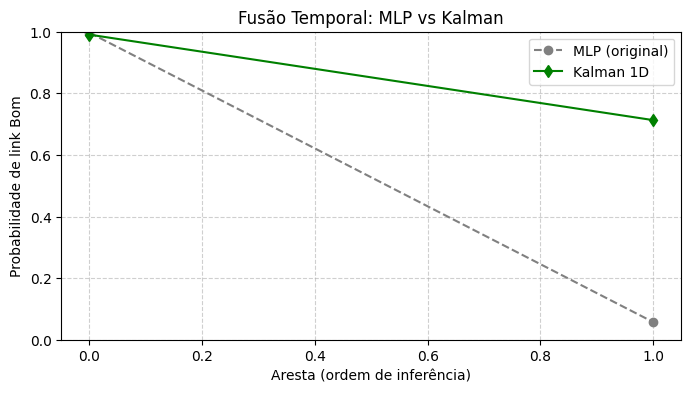


Saída com Kalman:
Aresta 0: MLP=1.00 | Kalman=0.99 -> Classe 1 (Bom)
Aresta 1: MLP=0.06 | Kalman=0.71 -> Classe 1 (Bom)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 2) Filtro de Kalman 1D (no logit)
# -------------------------------
def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class Kalman1D:
    def __init__(self, Q=0.05, R=0.25):
        """
        Q = variância do processo (quão rápido o estado pode mudar)
        R = variância da observação (ruído da medição)
        """
        self.Q = Q
        self.R = R
        self.z_est = 0.0   
        self.P = 1.0       

    def update(self, p_now):
        y = logit(p_now)

        # predição
        z_pred = self.z_est
        P_pred = self.P + self.Q

        # ganho de Kalman
        K = P_pred / (P_pred + self.R)

        # atualização
        self.z_est = z_pred + K * (y - z_pred)
        self.P = (1 - K) * P_pred

        # retorna probabilidade suavizada
        return sigmoid(self.z_est)

# -------------------------------
# 3) Série de probabilidades do MLP (classe "Bom")
# -------------------------------
prob_ml_series = probs[:, 1].numpy()

# -------------------------------
# 4) Aplicar Kalman
# -------------------------------
kf = Kalman1D(Q=0.05, R=0.25)
prob_kalman = [kf.update(p) for p in prob_ml_series]

# -------------------------------
# 5) Plot comparativo
# -------------------------------
plt.figure(figsize=(8,4))
plt.plot(prob_ml_series, 'o--', label="MLP (original)", color="gray")
plt.plot(prob_kalman,  'd-',  label="Kalman 1D",      color="green")
plt.title("Fusão Temporal: MLP vs Kalman")
plt.xlabel("Aresta (ordem de inferência)")
plt.ylabel("Probabilidade de link Bom")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# -------------------------------
# 6) Decisão final pós-Kalman
# -------------------------------
tau = 0.5
y_pred_kf = (np.array(prob_kalman) >= tau).astype(int)

CLASS_NAMES = {0: "Ruim", 1: "Bom"}
print("\nSaída com Kalman:")
for i, (p_raw, p_kf, c) in enumerate(zip(prob_ml_series, prob_kalman, y_pred_kf)):
    print(f"Aresta {i}: MLP={p_raw:.2f} | Kalman={p_kf:.2f} -> Classe {c} ({CLASS_NAMES[c]})")
